# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
1. To develop a better solution by changing the baseline model.
2. To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [4]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time
import random

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

Upload the `test.csv` and `training.csv` files that you can download from "campus virtual".

In [9]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 30)                  │       1,105,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,143,518 (4.36 MB)

 Trainable params: 1,143,518 (4.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
batch_size = 128
epochs = 50

def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.1263 - val_loss: 0.0849
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0741 - val_loss: 0.0607
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - loss: 0.0441 - val_loss: 0.0446
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 0.0301 - val_loss: 0.0419
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.0248 - val_loss: 0.0387
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.0213 - val_loss: 0.0381
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - loss: 0.0207 - val_loss: 0.0386
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.0202 - val_loss: 0.0411
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - loss: 0.0222 - val_loss: 0.0403
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step - loss: 0.0211 - val_loss: 0.0423
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - loss: 0.0218 - val_loss: 0.0398
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 41s 3s/step - loss: 0.0199 - val_lo

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Mean pixel error:  tf.Tensor(1.874476, shape=(), dtype=float32)


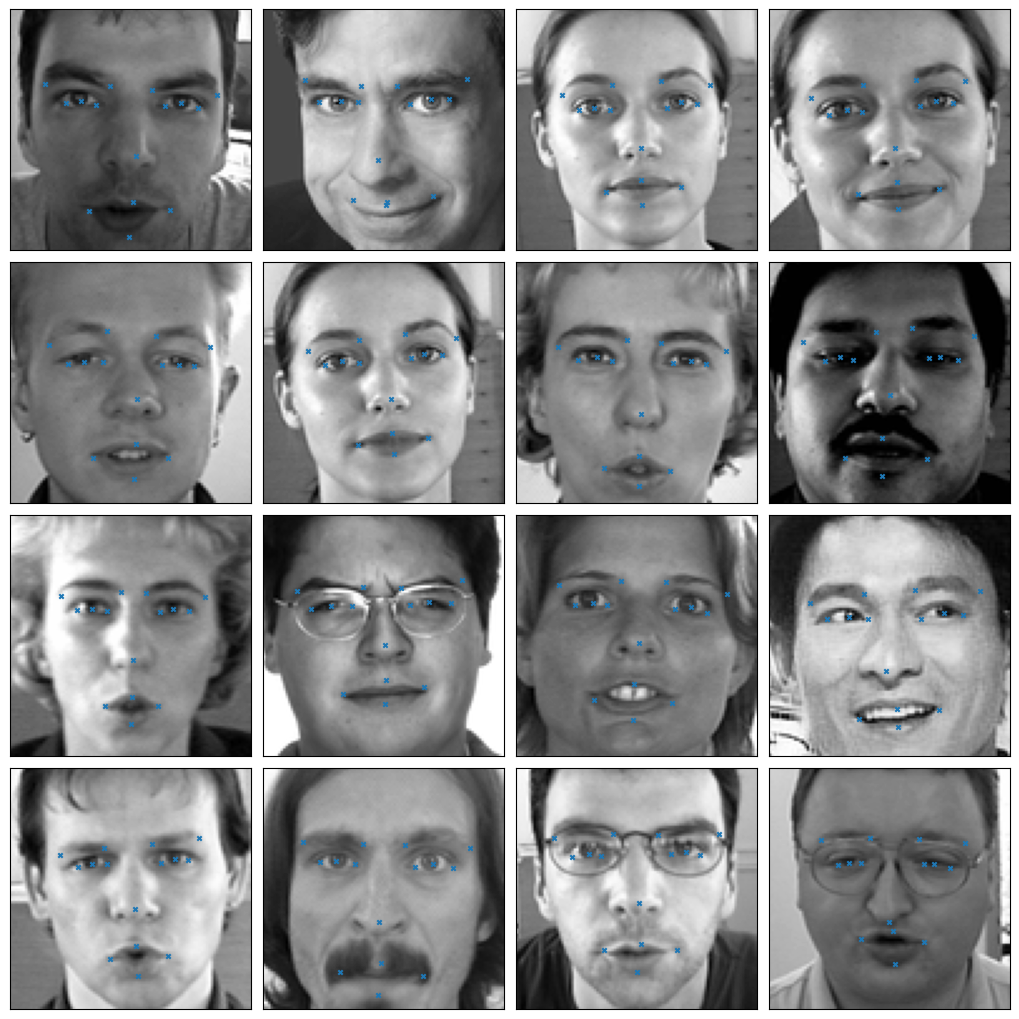

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

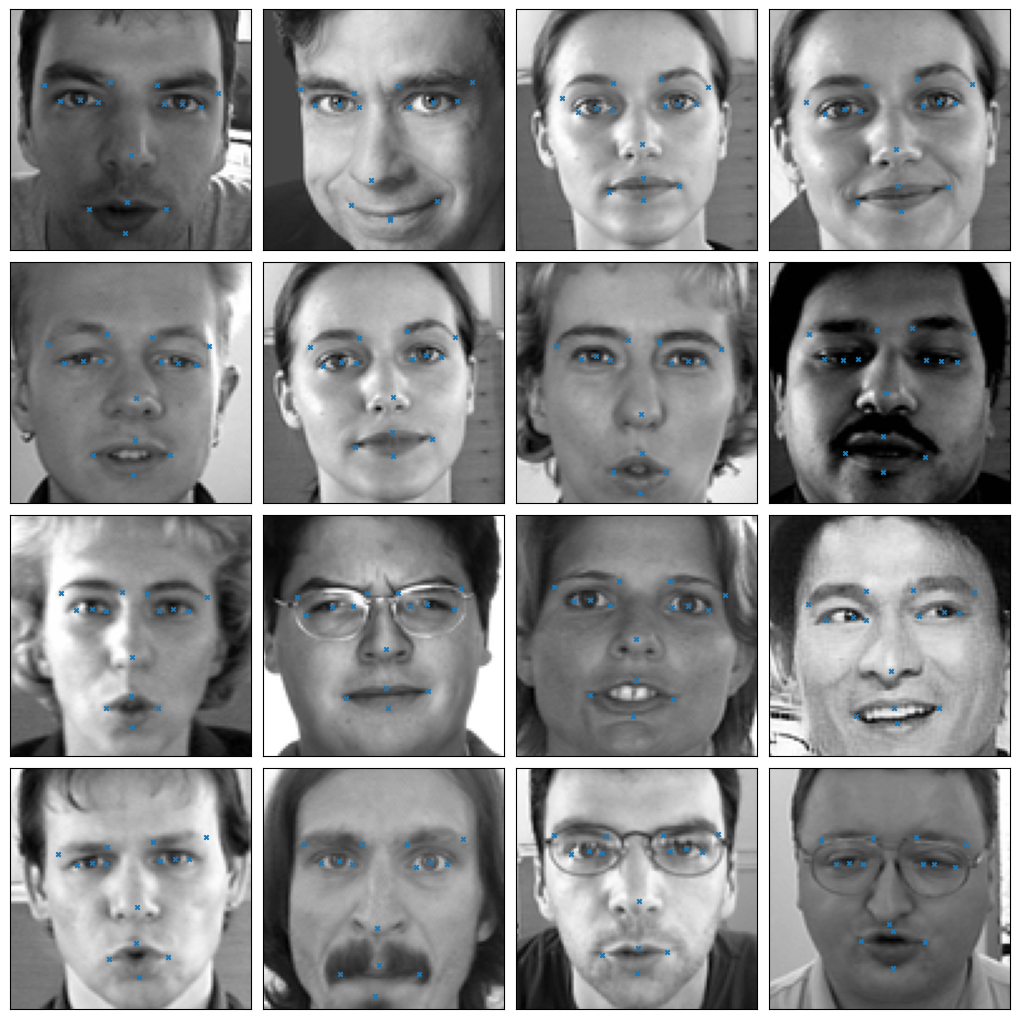

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Your (better) solution

In [ ]:
# your code here

Without data augmentation:



Number of samples in training.csv : 2140
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

 Sample image with labels:
(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


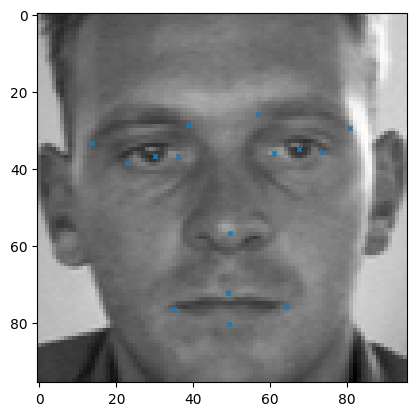

In [11]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

# loading data

X, y = load()

print("\n Sample image with labels:")
plot_sample(X[13],y[13])

# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)



In [12]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(2, 2), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 30)                  │       1,105,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,312,798 (5.01 MB)

 Trainable params: 1,312,798 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

batch_size = 128
epochs = 50

def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true)))

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Initial learning rate
    decay_steps=10000,            # Number of steps before the learning rate decays
    decay_rate=0.6,               # Decay rate (multiplier for learning rate)
    staircase=True                # Whether the decay should be in a staircase (discrete) manner
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss=root_mean_squared_error, optimizer=optimizer)

#model.compile(loss=root_mean_squared_error, optimizer=keras.optimizers.Adam(learning_rate=0.001))


# Create the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',   # Monitors the validation loss
    patience=5,           # Number of epochs with no improvement before stopping
    verbose=1,             # Prints when training stops
    restore_best_weights=True  # Restores the model with the best weights found during training
)


#optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 15s 672ms/step - loss: 0.4962 - val_loss: 0.2981
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - loss: 0.2745 - val_loss: 0.2122
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.2049 - val_loss: 0.1752
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1702 - val_loss: 0.1516
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1481 - val_loss: 0.1403
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1339 - val_loss: 0.1217
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.1193 - val_loss: 0.1118
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1087 - val_loss: 0.1048
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1018 - val_loss: 0.0979
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0963 - val_loss: 0.0942
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0900 - val_loss: 0.0896
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Mean pixel error:  tf.Tensor(1.1245759, shape=(), dtype=float32)


ok

In [40]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(2, 2), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

batch_size = 128
epochs = 50

def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true)))

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Initial learning rate
    decay_steps=100000,            # Number of steps before the learning rate decays
    decay_rate=0.6,               # Decay rate (multiplier for learning rate)
    staircase=True                # Whether the decay should be in a staircase (discrete) manner
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss=root_mean_squared_error, optimizer=optimizer)



# Create the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',   # Monitors the validation loss
    patience=5,           # Number of epochs with no improvement before stopping
    verbose=1,             # Prints when training stops
    restore_best_weights=True  # Restores the model with the best weights found during training
)



model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_75 (Conv2D)                   │ (None, 96, 96, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_75 (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_76 (Conv2D)                   │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_76 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_77 (Conv2D)                   │ (None, 24, 24, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_77 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_25 (Flatten)                 │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 30)                  │       1,105,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,312,798 (5.01 MB)

 Trainable params: 1,312,798 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 439ms/step - loss: 0.4688 - val_loss: 0.2916
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.2599 - val_loss: 0.2041
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.1935 - val_loss: 0.1670
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1595 - val_loss: 0.1435
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.1376 - val_loss: 0.1275
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1227 - val_loss: 0.1127
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1097 - val_loss: 0.1000
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0986 - val_loss: 0.0960
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0911 - val_loss: 0.0849
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0845 - val_loss: 0.0818
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0795 - val_loss: 0.0782
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0343 - val_loss: 0.0436
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0341 - val_loss: 0.0454
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0347 - val_loss: 0.0429
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0327 - val_loss: 0.0417
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0318 - val_loss: 0.0445
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0354 - val_loss: 0.0430
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0326 - val_loss: 0.0437
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0324 - val_loss: 0.0408
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0317 - val_loss: 0.0409
Epoch 10/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0304 - val_loss: 0.0411
Epoch 11/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0312 - val_loss: 0.0428
Epoch 12/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0

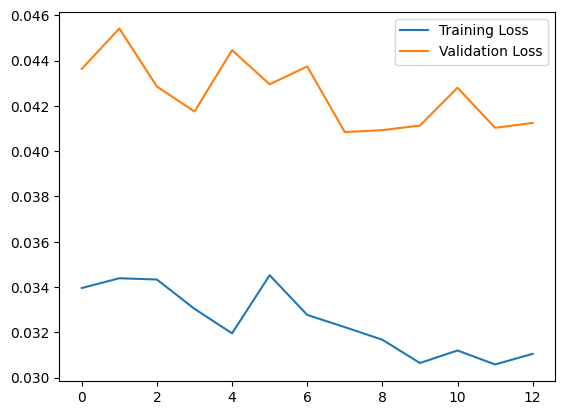

In [42]:
import matplotlib.pyplot as plt

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


With data augmentation:



Number of samples in training.csv : 2140
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

 Sample image with labels:
(3755, 96, 96, 1)
(805, 96, 96, 1)
(805, 96, 96, 1)


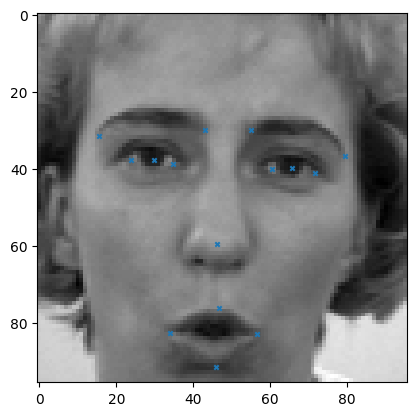

In [47]:
# loading data

FTRAIN = 'training.csv'
FTEST = 'test.csv'

def load(test = False, cols = None, augment=False):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    X = X.reshape(df.shape[0], 96, 96)

    # Apply augmentations like random flipping
    if augment:
        X_augmented = []
        y_augmented = []

        for i in range(X.shape[0]):
            # Add the original image
            X_augmented.append(X[i])
            y_augmented.append(y[i])

            # Apply horizontal flipping
            X_augmented.append(np.fliplr(X[i]))
            y_augmented.append(np.copy(y[i]))

            #Apply random brightness adjustment
            if random.random() < 0.5:
                brightness_factor = random.uniform(0.7, 1.3)  # Random factor between 0.7 and 1.3
                X_augmented.append(np.clip(X[i] * brightness_factor, 0, 1))  # Adjust brightness
                y_augmented.append(np.copy(y[i]))

        # Convert the augmented list back to arrays
        X_augmented = np.array(X_augmented)
        y_augmented = np.array(y_augmented)

        return X_augmented, y_augmented

    return X, y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

# loading data

X, y = load(augment = True)

print("\n Sample image with labels:")
plot_sample(X[13],y[13])

# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

In [48]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3,3), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(2, 2), activation="relu", padding="same", kernel_regularizer=regularizers.l2(0.001)),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam

batch_size = 128
epochs = 50

def root_mean_squared_error(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred - y_true)))

# Define the learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Initial learning rate
    decay_steps=10000,            # Number of steps before the learning rate decays
    decay_rate=0.6,               # Decay rate (multiplier for learning rate)
    staircase=True                # Whether the decay should be in a staircase (discrete) manner
)

optimizer = Adam(learning_rate=lr_schedule)

model.compile(loss=root_mean_squared_error, optimizer=optimizer)



# Create the EarlyStopping callback
early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',   # Monitors the validation loss
    patience=5,           # Number of epochs with no improvement before stopping
    verbose=1,             # Prints when training stops
    restore_best_weights=True  # Restores the model with the best weights found during training
)



model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return tf.math.sqrt(tf.math.reduce_mean(tf.math.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_93 (Conv2D)                   │ (None, 96, 96, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_93 (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_94 (Conv2D)                   │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_94 (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_95 (Conv2D)                   │ (None, 24, 24, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_95 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_31 (Flatten)                 │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 30)                  │       1,105,950 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,312,798 (5.01 MB)

 Trainable params: 1,312,798 (5.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 290ms/step - loss: 0.3841 - val_loss: 0.1801
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.1630 - val_loss: 0.1274
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.1210 - val_loss: 0.1086
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.1018 - val_loss: 0.0945
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0904 - val_loss: 0.0844
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0821 - val_loss: 0.0786
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0766 - val_loss: 0.0722
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0713 - val_loss: 0.0699
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0683 - val_loss: 0.0693
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0656 - val_loss: 0.0643
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0632 - val_loss: 0.0632
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0397 - val_loss: 0.0467
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0390 - val_loss: 0.0472
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0397 - val_loss: 0.0470
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0393 - val_loss: 0.0464
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.0397 - val_loss: 0.0469
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.


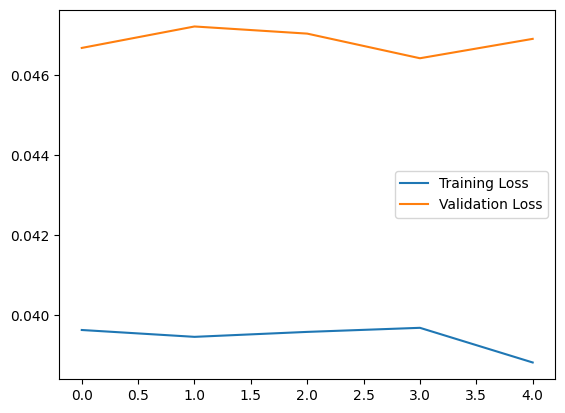

In [49]:
import matplotlib.pyplot as plt

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.5 pixels is ok. If your get 1.4 is very good. If you get 1.2 or less, it is an outstanding result!

**Answer**: The mean pixel error is: 1.53132

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: I tried many, many different strategies for lowering the mean pixel error. Firstly, I added another convolutional layer and altered the the number of filters in each convolutional layer to be in ascending order. As the layers get deeper, the capture more comlpex patterns so it makes sense to start off smaller for the top layer which captures the simpler features. I tried many different combinations, but 3 layers with 64, 128, and 256 filters worked best for me in the end. I also altered the dimensions of the kernels in descending order with similar reasoning that as the layers get deeper, they capture more specific patterns. Thus, the first layer has the largest dimensions to capture more general features and as we go deeper, the dimensions of the kernels decrease.

Secondly, I added L2 regularization into my model to regularize the filters with a step size of 0.001. I tried many different step sizes ranging between 0.1 and 0.00001 and also tried using combined L1/L2 regularization, but L2 worked the most consistently for me. I also implemented a learning rate schedule with exponential decay to decrease my learning rate every certain number of training steps so that my regularization would be more dynamic. I used the Adam optimizer with this learning rate schedule. Additionally, I have early stopping going on which would interupt my training if there was no improvement in the validation loss after a certain number of epochs. Both of these techniques made a big difference for me. I think regularization in general makes a big difference, which makes sense given that it prevents overfitting.

I ended up using a little bit of dropout, right before my dense layer, but generally when I used more of it, it made my results worse which I was surprised by because I figured that it would help. Also, I tried to implement data augmentation by flipping the images and adjusting their brightness, but I really could not get that to give me better results either. I included it here and trained using the model that worked best for me with the not augmented data, but alas, the augmented data kept giving me worse results. Maybe it was an issue with how I was augmenting it.

A technique that I didn't fully try was separating features into eyes, nose, and mouth. I started to do it, but I talked to some of my classmates and they told me that some features were way more accurate than others and that skewed the results, which made sense to me because when I started to do it I could see my eye accuracy was way better than my nose accuracy. This is also reasonable because the eyes have way more points while the nose is just one dot. But maybe if I had separated the feautures all the way it would have improved my results.

I don't understand how, sometimes if I run it with everything the same, I get a different result even though I didn't change anything. I had my lowest mean pixel error at 1.46 and then I accidentally ran the code block again and my score was different and I couldn't get it to go back down again. I did get 1.12 one time and I left it in because looking at it made me happy, but I think it was some sort of error.
